# Week 6 - Logistic Regression

### Aims

By the end of this notebook you will be able to understand 

>* the binary logistic regression
>* the main performance metrics for classification
>* the improvement for the imbalanced data 
>* the basics of multi-class classification

1. [Setup](#setup)

2. [Binary Logistic Regression](#RBH)

3. [Model refinement](#refine)

4. [Regularization Example](#SKV)

5. [Imbalanced Data](#Imbal)

6. [Multi-class Example](#mclog)


This week we will be implementing the logistic regression for a classification problem. 

- We will start with the binary case and then look at some extensions of the logistic regression model
- For this purpose, the main data set is called `Default.csv` in the upcoming code snippets. You will have tasks tagged by (CORE) and (EXTRA) as usual. 
- For the multi-class example, we will turn back to the `iris data` example for the simplicity

---

# 1. General Setup <a id='setup'></a>

## 1.1. Packages

Now lets load in the packages you wil need for this workshop. Maybe there are some missing packages below or the ones with that is not necessary based on your

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Other necessary packages
from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
import warnings # prevent warnings
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold #About randomized search over parameters
from scipy.stats.distributions import uniform, loguniform # About creating random C values for regularization

# from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# from imblearn.metrics import classification_report_imbalanced
# import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

##  1.2 User Defined Helper Functions

Below are three helper functions we will be using in this workshop. You can create your own if you think it is necessary OR directly use already available helper functions within `sklearn library`.  

- `tidy_scores()`: Simple function for getting the summary of cross-validation results in a tidy way.
- `pretty_confusion_matrix()`: Returns the confusion matrix in a nicer way but works for only binary classification!
- `roc_plot()` : ROC curve plotting function based on a given threshold

You can modify the following functions based on your needs as well. These practices would be important while you are working on your project either. 

In [3]:
# tidy the output into a dataframe
# We will use for getting the summary of cross-validation results in some parts
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_score":"val_score"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

In [4]:
# this creates the matplotlib graph to make the confmat look nicer
# WARNING 1: IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !!!
# WARNING 2: The locations of TP, FP, TN, and FN are varying when you compared with our notes !!!

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [5]:
# For ROC curve plotting function
def roc_plot(threshold = 0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show() 

## 1.3 Data

The dataset consists of **10000** individuals and whether their credit card has defaulted or not. 

Below is the column description: The main aim is to build the model using Logistic Regression and predict the person who is defaulted or not (classifying each individual). The included columns in the data set are as follows:

* `default` - Whether the individual has defaulted

* `student` - Whether the individual is the student

* `balance` - The balance in the individual's account

* `income` - Income of an individual

We read the data into python using pandas.





In [6]:
df_default = pd.read_csv("Default.csv", index_col=0)

# Lets just drop the student varible, 
# for simplicity we will focus on two main predictors; balance and income
df_default = df_default.drop("student", axis=1)
df_default.head()

,default,balance,income
1,No,729.526495,44361.62507
2,No,817.180407,12106.13470
3,No,1073.549164,31767.13895
4,No,529.250605,35704.49394
5,No,785.655883,38463.49588


We will start by doing explanatory data analysis (EDA) to examine the data set itself as usual, to get more insight about the data set. 

---

### 🚩 Exercise 1 (CORE)

Examine the structure of the data. Answer the following questions simply;

1. Do you observe anything from descriptive statistics that may influence our models?
2.  Are there any missing values in your data ? 
3. Look at how the varibles relate to each other (Response: Default, Predictors: Balance and Income) 

<details><summary><b><u>Hint</b></u></summary>
    
Maybe some scatterplot and boxplot for each feature in terms of different response class will be useful
    
</details>

---

**!!! Add your text solution here !!!**


---

### 🚩 Exercise 2 (CORE)

1. Lets now create our feature matrix and response varible.
2.  Split the data into training and test sets (**Is there anything you should try account for when splitting the data ?**) Use the test size as $10\%$ of the whole sample
3. Convert your response variable into the numerical format

>- For data splitting consider the the additional argument inside of `train_test_split` function, stratify in terms of the response data set. Otherwise, without stratify argument. 
>- You can recall the details from here 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html



---

**!!! Add your text solution here !!!**


# 2. Logistic Regression <a id='RBH'></a>

As we recall from our notes, for a binary output $y \in \lbrace 0, 1 \rbrace$, **logistic regression** is a classifier that can be seen a simple generalization of linear regression by making two changes. 

- First, we replaced the **Gaussian** distribution of the output $y$ with a **Bernoulli** distribution. 
- Second, we pass the linear function of the inputs, $\mathbf{w}^T\mathbf{x}$, through a **link function** $g: \mathbb{R} \rightarrow [0,1]$. That is, we assume $y \sim Bern( g(\mathbf{w}^T\mathbf{x}))$

The link function takes values in the unit interval to ensure that the conditional probability of a success, 

$$p(y =1 \mid \mathbf{x}) = E[y | \mathbf{x}] = g(\mathbf{w}^T\mathbf{x})$$

is between zero and one. Specifically, in logistic regression, we select the **logistic** link function (sigmoid as an S-shaped), defined as 

$$g(\mathbf{w}^T\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^T\mathbf{x})}$$

Putting these two steps together, the logistic regression model is:

$$y \sim Bern\left( \left[1 + \exp(-\mathbf{w}^T\mathbf{x})\right]^{-1} \right)$$

To apply this idea with the help of sklearn, the main function that we need to use is `LogisticRegression`. 

- There are important details regarding the implementation of it but the most important note to keep in mind is that the regularization is applied by default with the first input argument `penalty='l2'`
- For further reading, please refer to this website, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### 🚩 Exercise 3 (CORE)

- Fit a binary logistic regression model to the training data by using both balance and income as features, **without any regularization**. 
- State the the accuracy score of the model over the testing data

<details><summary><b><u>Hint</b></u></summary>
    
You can consider the `score` function directly
    
</details>


## 2.1 Model Predictions

The fitted `LogisticRegression` objects provide multiple prediction methods. Specifically: 

- `predict` which predicts the class label (either 0 or 1), 
- `predict_proba` which predicts the class probabilities, and 
- `predict_log_proba` which predicts the log probabilities of each class


---

### 🚩 Exercise 4 (CORE)

Based on the above fitted logistic regression model, calculate

1. the predictions of the class probabilities
2. Calculate the mean squared error, accuracy score, AUC score of your logistic regression model's predictions. The function `mean_squared_error` , `accuracy_score` and `roc_auc_score` from `sklearn.metrics` will be useful for this. 

See the function documentation if you need [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

---

### 🚩 Exercise 5 (CORE)

Consider the given pipeline for the logistic regression model simply. 

- Run 5-fold Cross Validation for this calculation and use the helper function `tidy_scores()` created above for average score calculation.

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps

# One can add more model in the dictionary
model_dict = {"log": LogisticRegression(random_state = 42, penalty = "none")}

#print(model_dict[model_name]) 

for model_name in model_dict:
    logistic_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])])
    

logistic_pipe

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(penalty='none', random_state=42))])

## 2.2 Performance Metrics

A binary classifier can make two types of errors:

- Incorrectly assign an individual __who defaults__ to the __no default__ category. (FN)
- Incorrectly assign an individual who __does not default__ to the __default__ category. (FP)

where Defaulted (coded as 1) and not defaulted (coded as 0). As we can recall from our notes once again, the main quantities are; 


$$\text{TP} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=1),\quad \text{FP} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=1)$$
$$\text{FN} = \sum_{n=1}^N \mathbb{I}(y_n=1)\mathbb{I}(\widehat{y}_n=0), \quad \text{TN} = \sum_{n=1}^N \mathbb{I}(y_n=0)\mathbb{I}(\widehat{y}_n=0)$$


where $y_n$ is the true class and $\widehat{y}_n$ is the estimated class. While the overall error rate is low, the error rate among individuals who defaulted is very high. 

- From the perspective of a credit card company that is trying to identify high-risk individuals, this error rate among individuals who default may well be unacceptable.
- From a different persopective, the **lower FN** values are more important compared to the **lower FP** values in this case

---

### 🚩 Exercise 6 (CORE)

- Derive the confusion matrix for the logistic regression model with two predictors by following the above pipeline. Afterwards, derive the followings;

1. False Positive Rate (FPR)
2. True Positive Rate (Recall)
3. Precision
4. F1-score

without using any additional built-in function from any module (You need to recall the definitions from our notes) 

$$
\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP}+ \text{TN}}, \hspace{0.5cm} \text{Recall (TPR)} = \frac{\text{TP}}{\text{TP}+ \text{FN}} \hspace{0.5cm}
\text{Precision} = \frac{\text{TP}}{\text{TP}+ \text{FP}}
$$


$$
\text{F1-Score} = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right) = \frac{\text{2TP}}{\text{2TP + FP + FN}}
$$

- What can you say about the model performance in terms of Confusion Matrix and obtained quantities 

In [ ]:
log_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state = 42, penalty = "none"))])

log_pipe.fit(X_train, y_train)

# use the classifier to predict the based on testing data    


# get the confusion matrix as a numpy array


**!!! Add your comments about the model performance here !!!**


**F1-score**

- As we have seen above, F1-score is a combination of Recall and Precision. 
- It is typically used when there is an __uneven class distribution__ due to a large number of True Negatives that you are not as focused on. 

__Notes__

- Using `sklearn.metrics` this can be gained using `f1_score(y_true=y_test, y_pred=predictions)`

---

### 🚩 Exercise 7 (CORE)

1. Calculate the $F1$ score using `f1_score` function for the logistic regression model with two predictors and compare your result with your calculation obtained before !
2. Draw ROC curve for the same model. Explain the obtained graphical result.  

---

**!!! Add your comments here !!!**


## 2.3 Model Refinement <a id='refine'></a>

For those coming from other programming / modeling languages this may be somewhat surprising, this strange default is probably the most common reason that results from sklearn might not immediately match results from other tools. 

- This behavior can be explicitly controlled via the penalty argument, namely C. 
- Note that if you did wish to include a penalty on the coefficients then just like with ridge or lasso it is necessary to tune this penalty parameter. 
- However, `LogisticRegression` does not use alpha for this tuning parameter but instead uses $C$ which is the inverse of the alpha we have been using - i.e. smaller values of $C$ imply more regularization.

For our logistic regression model, lets start by looking at the effects of changing the regularization strength ($C$). Notice that the default value is $C = 1.0$ in `LogisticRegression` function.


---

### 🚩 Exercise 8 (CORE)

1. By completing the following code snippet, derive the related graph. Based on the graphical output, discuss the effects of changing the regularization strength( $C$ ) shortly. 

Note: You can look at the details of `plot_decision_regions` function but not obligatory to run the code !
http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/

In [ ]:
# First, install the mlxtend if necessary
# !pip install mlxtend

In [ ]:
from mlxtend.plotting import plot_decision_regions

scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Validation data', 'alpha': 0.7}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, axes = plt.subplots(figsize=(15,5), ncols=2, nrows = 2)
    axes = axes.flatten()
    
    for i, c in enumerate([0.01, 0.05, 1., 10.]):
        
        log_pipe = Pipeline([
            ("scaler", ______()),
            ("model", LogisticRegression(C = c, random_state=42, penalty = "none"))])

        log_pipe.fit(________, _______)
    
        plot_decision_regions(X_train, y_train, clf = log_pipe, 
                              legend = 2, X_highlight = X_val[y_val==1],
                              contourf_kwargs = contourf_kwargs,
                              scatter_kwargs = scatter_kwargs,
                              scatter_highlight_kwargs = scatter_highlight_kwargs,
                              ax = axes[i]
                             )
        
        axes[i].set_title("C = {}".format(c))
        
    plt.suptitle("Logistic Regression Decision Boundaries (Defaulted Validation Data Circled)")

## 2.4. Grid Search

- Before we start searching over hyperparameters, its worth noting that some of the folds may not have the same distribution of the classes. 
- This means we could get a validation score that may be a poor estimate of performance (for example we may have a fold with very few positive classes or more than usual). 
- Therefore when doing our gridsearch/randomsearch, we should use a `StratifiedKFold` to ensure the distribution of classes in our folds reflects the distribution in the larger data.

You can check the details for `RandomizedSearchCV` function from here 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [ ]:
from scipy.stats.distributions import uniform, loguniform

log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42))])

C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

log_rs = RandomizedSearchCV(______, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "accuracy", 
                            random_state = 42,
                            return_train_score = True)

log_rs.fit(______, ______)

### 🚩 Exercise 9 (CORE)

1. Convert your `log_rs.cv_results_` into pandas data frame and sort the values in terms "mean_test_accuracy" in descending order by using `sort_values` function !!!

2. Look at the first 6 values in this sorted values and make comments on test accuracy !!!

In [ ]:
# About the summary of best 6 models 
# Convert your log_rs.cv_results_ into pandas data frame and sort the values in terms 
# "mean_test_accuracy" in descending order by using sort_values !!!

# Look at the first 6 values in this sorted values and make comments on test accuracy !!!


## 2.5. Logistic with Regularization <a id='SKV'></a>

- Note that regularized logistic regression is implemented using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers in scikits-learn. Note that regularization is applied by default as $L_2$.

- So, to compare logistic regression with any regularization, play with the parameters of `LogisticRegression` function.

### 🚩 Exercise 10 (EXTRA)

1. Rebuild your model described above (`log_rs`) with regularization type `L1` norms 
2. Derive the summary performance for the obtained model and discuss your findings

##  3. Improving Models with Imbalances <a id='Imbal'></a>

There are a number of methods to address imbalances in a dataset when we refine our models, such as:

1. Considering the suitable performance metric
2. Weighting the classes in the model during training
3. Resampling the data.

Herein, the main focus is the suitable resampling to change the distribution of the classes in our training data.

## 3.1. Changing Metric

__Optimising for Accuracy__ 

During hyperparameter cross-validation, we selected the model with the best __overall accuracy__. 

- This gives us a model with the smallest possible total number of misclassified observations, irrespective of which class the errors come from. 

- ML algorithms typically optimize a reward or cost function computed as a sum over the training examples, the decision rule is likely going to be biased toward the majority class$^1$.

__Notes__

- _"In other words, the algorithm implicitly learns a model that optimizes the predictions based on the most abundant class in the dataset, in order to minimize the cost or  maximize the reward during training."_<sup>1</sup>.

- You can check the details of `classification_report` function from here 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [ ]:
# This is the classification report based on the accuracy metric
from sklearn.metrics import classification_report

print(pd.DataFrame(classification_report(y_test, 
                                   bal_log_rs.predict(X_test), 
                                   labels = None, 
                                   target_names = list(LE.classes_), 
                                   sample_weight = None, 
                                   output_dict = True)).round(2))

- Changing the metric for what is defined as the _"best model"_ can help us prioritise models that make particular errors.

For example, a credit card company might particularly wish to avoid incorrectly classifying an individual who will default, whereas incorrectly classifying an individual who will not default, though still to be avoided, is less problematic. 

- In this case, __recall__ would therefore be a useful metric to use.

Rather than running another cross-validation again, provided that in `scoring` you used a list that contained "recall", we can just use our results data to pick the model with the best "recall" instead of accuracy.

---

### 🚩 Exercise 11 (CORE)

Consider the following function for the new metric, `recall`, and then derive a similar classification report that you observed above

In [ ]:
from sklearn.base import clone

# we refit the best accuracy model on all the training data
# so lets do that for the best other metric models
def manual_refit(input_model, X, y, gs, metric, disp_df=[]):
    output_model = clone(input_model)
    
    gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_" + metric, ascending = False)
    
    if disp_df:
        display(gs_df[disp_df].head())
    
    params = gs_df["params"].iloc[0]
    output_model = output_model.set_params(**params)
    output_model = output_model.fit(X, y)
    
    return output_model

rec_model = manual_refit(_______, ______, ______, bal_log_rs, "recall")

## 3.2. Weighting the classes

During model fitting we can assign a larger penalty to wrong predictions on the minority class.

The heuristic used for `class_weight="balanced"` in Scikit-Learn is:

$$
\frac{n}{Nc \times \sum\limits^n_{i=1}I(y_i \in S)}
$$

where $n$ are the number of samples, $Nc$ the number of classes, $I$ is an indicator function, and $S$ contains the class elements. Remember that the default value is `class_weight=None`. 

---

### 🚩 Exercise 12 (EXTRA)

Conduct a `randomsearch` using the following code chunk, this time also looking at both `C` and `class_weight`. Has this improved performance? 

1. When you change your refit with other scoring alternatives rather than using "accuracy", what is the impact of it on the result (test recall)
2. Is there any improvement when `n_splits = 10` ?    

In [ ]:
log_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(C = c, random_state=42, penalty = "none"))])
    
# specify parameters and distributions to sample from
log_param_dist = {
    'model__C':loguniform(C_list[0], C_list[-1]),
    'model__class_weight': [None, "balanced"]
}

bal_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

bal_log_rs.fit(X_train, y_train)

# To convert it as a data frame
bal_log_rs_df = pd.DataFrame(bal_log_rs.cv_results_)

#This is sorted for accuarcy, when you change your refit argument above, be careful about that
bal_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__class_weight", 
                                                                  "param_model__C", 
                                                                  "mean_test_accuracy", "mean_test_recall", 
                                                                  "std_test_accuracy"]].head()

---

### 🚩 Exercise 13 (EXTRA)

- Derive the confusion matrix for each model described above, `rec_model` and `bal_log_rs` using the confusion_matrix function. 
- State the similarity and  differences of the obtained confusion matrices 

## 3.3. Resampling

We can change the distribution of the classes in our training data. As we discussed in the notes, there are two main approaches, called as,

- Down-sampling the majority class (Undersampling)
- Up-sampling the minority class (Oversampling)
 

### Under-Sampling

The Down-sampling (Undersampling) involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm. 

<div>
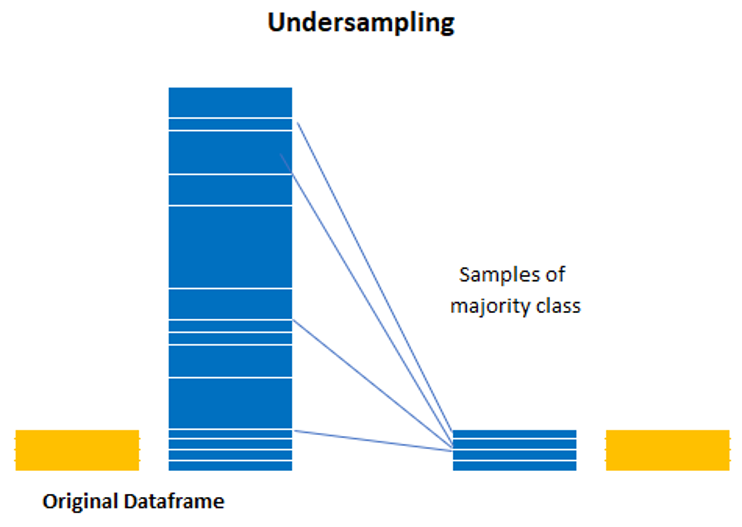
</div>

__Notes__

- `RandomUnderSampler` is part of the Imblearn package, which allows for a lot of techniques for working with imballanced data.
- There is a `resample` method in `scikit-learn` but Imblearn is a bit smoother to work with.
- If you want to use a sampler in a model pipeline then you can use the pipeline from imblearn. Using a sampler in a pipeline ensure you wont be training and validating your data on a smaller/larger sample than normal and get unrepresentative results!

You can check some of the details for `RandomUnderSampler` from here 

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [ ]:
# Install the imblearn if necessary 
# !pip install imblearn

In [ ]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler


log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=123)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1])}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train, y_train)

In [ ]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

### Oversampling
Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples.

<div>
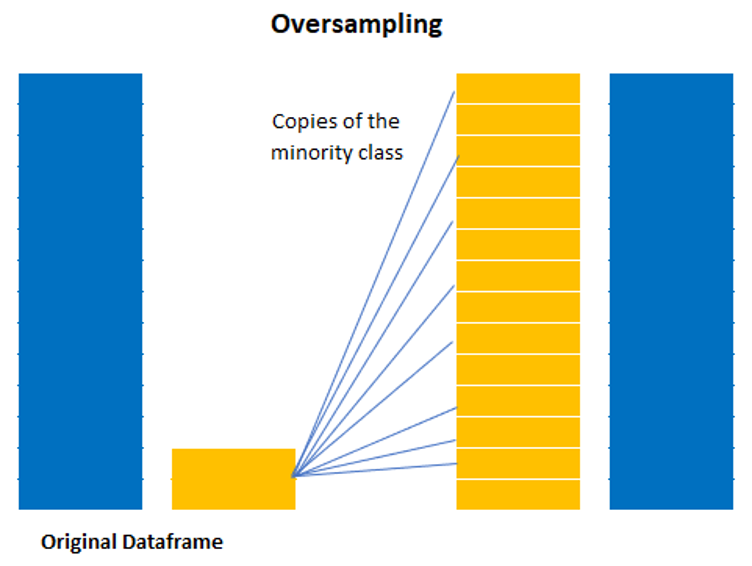
</div>

Note:
- Make sure to oversample after splitting the training and validation sets or you may "bleed" information into the validation sets of the model when trying to test a model
- In-other-words, make sure it is in a pipeline! If you understand the previous mechanism, you can write the `RandomOverSampler` case below !!!

### 🚩 Exercise 14 (CORE)

- Create a similar pipeline for oversampling strategy for the imbalanced data. It is very similar what you observed above as in `log_pipe`

- After getting the results in a similar way, compare the performance in terms of undersampling or oversampling

---
# 4 Multi-class Logistic <a id='mclog'></a>

For this part, basically we will use the `iris` data again, already available to use and it has nice properties in terms of class size over three species. 

- More clearly, this is an example where the response has **3 classes** but we **do not need to worry about the imbalanced issue**

In [27]:
# First load the data here
from sklearn.datasets import load_iris

# Loading data
raw_data = load_iris()
data_desc = raw_data.DESCR
data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)

# Some information on data set
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [29]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Some Visual Inspection on the data set

In [31]:
# Adding the species as a new column
data['species'] = raw_data.target
print(data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0  


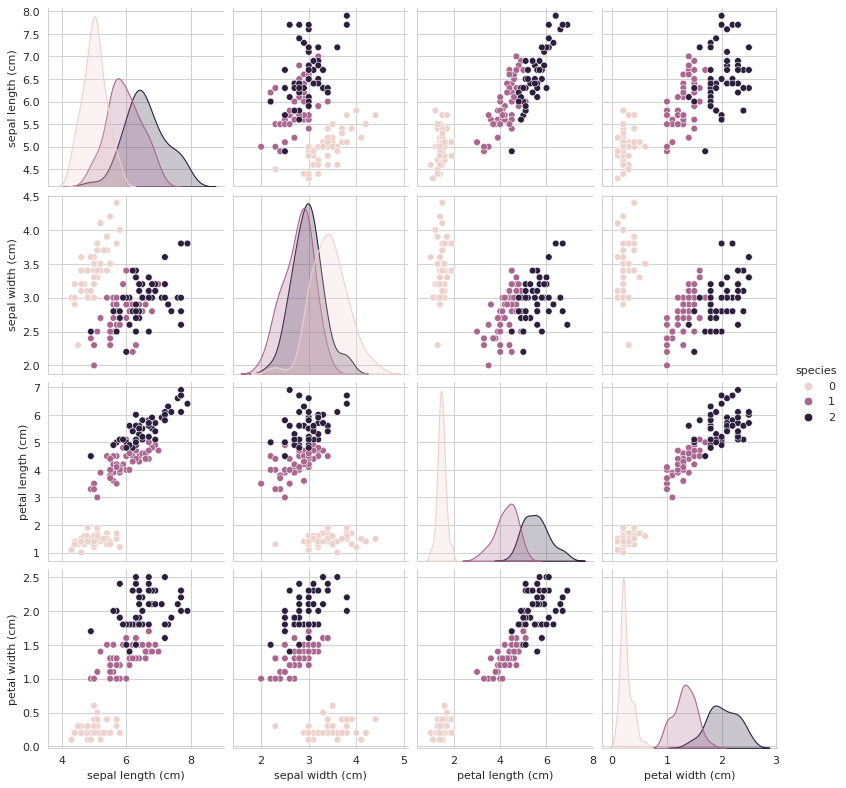

In [32]:
sns.set_style('whitegrid')
sns.pairplot(data, hue='species')
plt.show()


Since we will be attempting to predict the species of flower which is a finite list of categorical options (ie. Setosa, Virginica, Versicolor), we need to assign a numerical value for each of the species within dummy variables. Dummy variables are variables that take binary (True=1, False=0) assignments based on every category in a given column. For example, our categories are Setosa, Virginica and Versicolor. We will have a column for each of these species and will assign a 1 or 0 for each row depending on what species they are. So a sample row representing Setosa, will have the Setosa column value of 1 and the Virginica and Versicolor values would be assigned as 0.

In [33]:
# Consider species_label function as a helper 
# For iris data example 
def species_label(theta):
	if theta==0:
		return raw_data.target_names[0]
	if theta==1:
		return raw_data.target_names[1]
	if theta==2:
		return raw_data.target_names[2]

In [34]:
# data = pd.DataFrame(raw_data.data, columns=raw_data.feature_names)
data['species'] = [species_label(theta) for theta in raw_data.target]
#data['species_id'] = raw_data.target
print(data.head())

# Class size information
print(data.species.value_counts())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64


In [35]:
#Prepare the data set

#Encoding Species columns (to numerical values)
data['species'] = data['species'].astype('category').cat.codes
print(data['species'])

#Feature & Target Selection
# X = feature values, all the columns except the last column
X = data.iloc[:, :-1]
print(X.head())

# y = target values, last column of the data frame
y = data.iloc[:, -1]
print(y.head())

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int8
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int8


After partitioning your data set into training and testing with %80-%20 rule,

- Create `One-Vs-Rest Logistic` Regression pipeline and train your model
- Create `Multinomial Logistic` Regression pipeline and train your model

Under this method/strategy a multi-class classification dataset (in our case IRIS) is split into multiple binary classification chunks/datasets. Then a binary classifier (in our case SVC) is trained on each of the binary classification datasets and a prediction(s) is made using the model that has the most confidence value. The IRIS dataset will be split into individual datasets for each Species versus every other Species. Following are the details:

1. Binary Classification: setosa vs versicolor
2. Binary Classification: setosa vs virginica
3. Binary Classification: versicolor vs virginica

Side Not: The **OneVsRestClassifier** class is very easy to use and requires that a classifier that is to be used for binary classification be provided to the **OneVsRestClassifier** as an argument. For this purpose, we need to play around the argument `multi_class`

### 🚩 Exercise 15 (EXTRA)

- Test the performance of `One-vs-Rest` and `Multinomial` Logistic models
- Derive the confusion matrix for each model and compare the quantities to conduct a model comparison

---

**!!! Add your comments on obtained  !!!**
